#**Using Python Libraries for Handling WaPOR Data**

[![](https://raw.githubusercontent.com//wateraccounting/WaPORMOOC/main/images/colab-badge.png)](https://colab.research.google.com/github/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N03_Average_Seasonal_AETI_per_farm.ipynb?target="_blank")

#Notebook 3: Calculating areal average values using WaPOR data
In this Notebook we will show you how to calculate seasonal AETI and dekadal timeseries of AETI for different farms or group of farms (eg tertiary unit).   
The steps are:
1. Install and load necessary Python Libraries to manage raster files
2. Load and visualise seasonal WaPOR AETI created in [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb)
3. Calculate average seasonal AETI for each farm and calculate statistics
4. Calculate zonal statistics for tertiary unit
5. Visualise time series of dekadal AETI per farm

Exercises included in the Notebook needed for the MOOC quiz


**Data needed (same as for Notebook 02)**:

For the exercises of the [MOOC Python for geospatial analyses using WaPOR data](https://ocw.un-ihe.org/course/view.php?id=272) you can use the following data:

* Seasonal WaPOR AETI tiff file created in [Notebook 2 Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb)

* For the farm level analyses we will be using the WH_Fields.geojson file located in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC)).

We will also be using the same WaPOR data as used for [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb) for the temporal analyses:  
1. **Area**: Wad Helal in the Gezira Irrigation Scheme (you can find the "Wad_Helal.geojson" file in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC)).
2. **Type of Data**: AETI
3. **Spatial resolution**: Level 3
4. **Temporal resolution**: dekadal
5. **Start date**: 2022-10-01
6. **End date**: 2023-04-30

 © 2024 IHE Delft Licenced under CC BY SA Creative Commons



---



### **Step 1 Install and import required python libraries**

In [18]:
# Install required packages
%%capture
!pip install --upgrade xarray  --quiet
!pip install --upgrade geopandas --quiet
!pip install --upgrade rioxarray --quiet
!pip install rasterstats

In [19]:
# Import the required packages
from osgeo import gdal
import xarray as xr
import rioxarray as rioxr
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import matplotlib.colors as mcolors

### **N.B.**
>In this notebook we used additional Python Libraries called <font color='steelblue'>**`Xarray`**</font> and <font color='steelblue'>**`rioxarray`**</font>. <font color='steelblue'>**`Xarray`**</font> is a python library which simplifies working with labelled multi-dimension arrays such as stack of rasters and<font color='steelblue'>**`rioxarray`**</font> is an Xarray extension that allows reading and writing a wide variety of geospatial image formats compatible with Geographic Information Systems (GIS). Introducing these libraries is out of the scope of this Notebook, but for **[xarray](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)** and **[rioxarray](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html)** you can find good Notebooks that provide a good introduction about the libraries for a basic understanding.



---



## **Step 2 - Load and visualise seasonal WaPOR AETI**

We will now upload the Seasonal WaPOR AETI file you created  in [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb). This file as a .tif extension.

Execute the command below, click the `Choose Files` button, navigate to where you have saved the .tif file in your local drive and select the file.

In [20]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving Wad_Helal_seasonal_AETI.tif to Wad_Helal_seasonal_AETI (1).tif


The following script displays the data read using 'rioxarray' and plotted using the `matplotlib` Libary

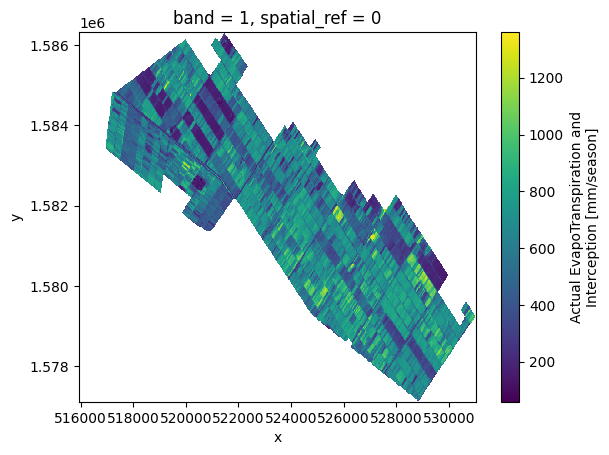

In [21]:
seasonal_AETI = '/content/Wad_Helal_seasonal_AETI.tif'      # Path to seasonal file
seasonal = rioxr.open_rasterio(seasonal_AETI)             # open the raster file
seasonal.plot()                                         # Display the raster file



You can see that the projection of the map is off, but the unit is correct. Another way is to read the file using 'rasterio'. The heading of the map is also generic. An alternative way to plot the map is shown below.  

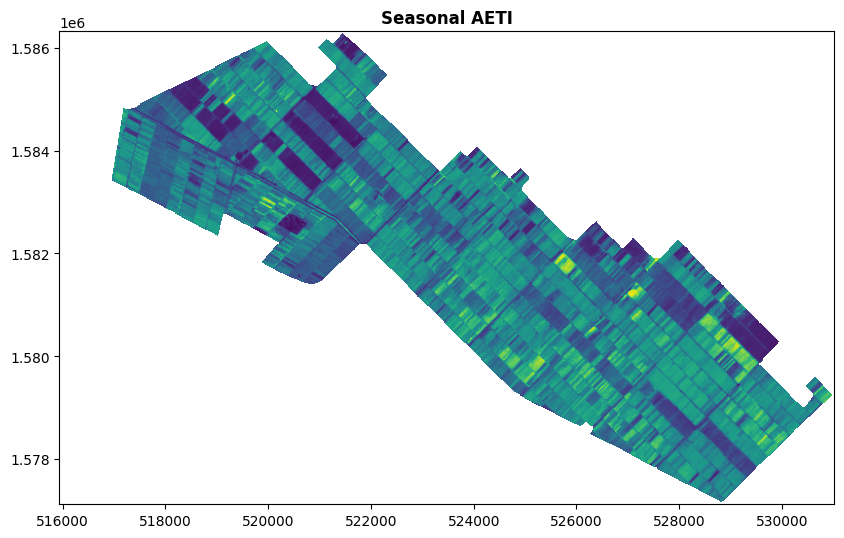

In [22]:
with rio.open(seasonal_AETI) as seasonal:                        # Open the raster file
    fig, ax = plt.subplots(figsize=(10, 10))                # Create a matplotlib figure and axis object with a specified size
    show(seasonal, ax=ax, title='Seasonal AETI')                 # Use rasterio's show function to display the raster data on the axes
    plt.show()                                              # Display the plot

To add more elements to the map you can adapt the script below. Try to change the colors used for the map (change the 'cmap' variable). For more information check [here](https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/)



In [ ]:
seasonal = rio.open(seasonal_AETI)
spatial_extent = (seasonal.bounds.left, seasonal.bounds.right, seasonal.bounds.bottom, seasonal.bounds.top)

# Read the first band
data = seasonal.read(1)

# Plotting
plt.figure(figsize=(12, 8))
plt.imshow(data, cmap='jet_r', vmin=np.nanmin(data), vmax=np.nanmax(data), extent=spatial_extent)
plt.colorbar(shrink=0.75, label='AETI [mm/season]')
plt.xlabel('Longitude [m]', fontsize=14)
plt.ylabel('Latitude [m]', fontsize=14)
plt.title('AETI [mm/season]', fontsize=16)
plt.show()



---



## **Step 3 - Calculate average seasonal AETI for each farm and calculate statistics**

Upload and read the area of interest. In this case the WH_Field.shp file that contains information about 214 individual fields within the Wad Helal irrigation block that cropped Wheat in the 2022/2023 winter season.

**NOTE:**

The file for the farms in this script is a .shp file. Create a .shp file from the geojson file in QGIS first. Dont forget to upload all dependencies in the same folder!



In [23]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving WH_Fields.cpg to WH_Fields (1).cpg
Saving WH_Fields.dbf to WH_Fields (1).dbf
Saving WH_Fields.prj to WH_Fields (1).prj
Saving WH_Fields.shp to WH_Fields (1).shp
Saving WH_Fields.shx to WH_Fields (1).shx


In [24]:
shapefile_path = '/content/WH_Fields.shp'


,id,yield,layer,path,geometry
0,3201,3.31,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518802.239 1582439.322, 518814.019 1..."
1,3202,3.10,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518813.176 1582497.245, 518826.226 1..."
2,3203,2.32,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518827.493 1582553.491, 518840.966 1..."
3,3204,3.30,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518838.855 1582607.637, 518846.432 1..."
4,3205,3.32,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518847.277 1582639.538, 518853.589 1..."
...,...,...,...,...,...
209,1220,3.17,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528152.674 1580025.052, 528174.556 1..."
210,1221,3.17,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528174.503 1580003.671, 528195.645 1..."
211,1222,1.98,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528069.161 1580109.373, 528153.308 1..."
212,1223,2.64,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528028.463 1580149.305, 528048.23 15..."


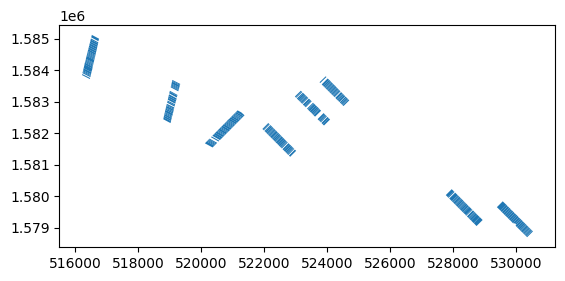

In [25]:
gdf = gpd.read_file(shapefile_path)
# Plotting the fields
gdf.plot()
gdf

Now we are adding the **mean** seasonal AETI for each of these farms.

In [26]:
# Convert CRS to EPSG:32636 if necessary
if gdf.crs != 'epsg:32636':
    gdf = gdf.to_crs(epsg=32636)

# filter out empty or null geometries
gdf = gdf[~(gdf['geometry'].is_empty | gdf['geometry'].isna())]

# Calculate zonal statistics for mean
gdf["mean_AETI"] = pd.DataFrame(
            zonal_stats(
                vectors=gdf,
                raster=seasonal_AETI,
                nodata=np.nan,
                all_touched=False
            )
        )["mean"]
gdf

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,yield,layer,path,geometry,mean_AETI
0,3201,3.31,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518802.239 1582439.322, 518814.019 1...",719.130769
1,3202,3.10,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518813.176 1582497.245, 518826.226 1...",775.375676
2,3203,2.32,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518827.493 1582553.491, 518840.966 1...",796.317647
3,3204,3.30,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518838.855 1582607.637, 518846.432 1...",784.365000
4,3205,3.32,BahiEddin11,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((518847.277 1582639.538, 518853.589 1...",764.680000
...,...,...,...,...,...,...
209,1220,3.17,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528152.674 1580025.052, 528174.556 1...",774.369136
210,1221,3.17,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528174.503 1580003.671, 528195.645 1...",786.183333
211,1222,1.98,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528069.161 1580109.373, 528153.308 1...",801.458730
212,1223,2.64,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528028.463 1580149.305, 528048.23 15...",NaN


In [28]:
gdf.sort_values(by='mean_AETI', ascending=False)

,id,yield,layer,path,geometry,mean_AETI
202,1213,3.30,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528373.613 1579804.111, 528393.909 1...",867.560000
199,1210,3.70,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528455.228 1579719, 528497.933 15796...",850.515789
201,1212,3.30,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528393.067 1579782.307, 528413.364 1...",848.180952
197,1208,3.26,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528522.458 1579656.119, 528591.384 1...",844.680488
200,1211,1.98,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528414.207 1579763.864, 528456.071 1...",842.278947
...,...,...,...,...,...,...
47,3323,2.44,BahiEddin21,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((516482.244 1584908.379, 516497.828 1...",NaN
48,3324,2.24,BahiEddin21,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((516496.984 1584969.655, 516505.407 1...",NaN
49,3325,2.22,BahiEddin21,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((516740.677 1584916.944, 516514.252 1...",NaN
212,1223,2.64,Hegeiliga_Median,D:/WA+/FAO_phase2/Python_for_geospatial_OCW/Fi...,"POLYGON ((528028.463 1580149.305, 528048.23 15...",NaN


We want to get the area for each of these farms and add this to the DataFrame.


In [ ]:
# Calculate area of each polygon in square meters
gdf['Area_sqm'] = gdf.area

# Initialize results DataFrame
gdf = gdf.copy()
gdf

<div class="alert alert-success">

**Exercise 1**

Which field (note Field ID) has the highest mean seasonal AETI and what is the amount in mm/season (round to integer - no decimal place)?

In which **tertiary unit** is the largest field located and what is the area in ha (with one decimal)?

<details>
  <summary>HINT</summary>

* Consider sorting the DataFrame
</details>
    
Note down the answers, you need them for the MOOC quiz!!

</div>

Why do the farms in BahiEddin21 have NaN values for the seasonal AETI?

<details>
  <summary>Answer</summary>

* There is no WaPOR data for this tertiary unit, so it didnt calculate seasonal AETI
</details>
    
</div>

We now want to get the timeseries statistics

**NOTE** Upload the WaPOR AETI dekadal data which you also used in Notebook 02. Dont forget to unzip the file!

In [ ]:
#upload .zipfile


#unzip file


In [ ]:
shapefile_path = '/content/WH_fields.shp'
folder_path = '/content/content/output/L3-AETI-D'

In [ ]:
def extract_identifier_from_filename(filename):   ## make sure to identify which part of the file name has date
    parts = filename.split('_')
    date_part = parts[6]
    return date_part.rstrip('.tif')

# Convert CRS to EPSG:32636 if necessary
if gdf.crs != 'epsg:32636':
    gdf = gdf.to_crs(epsg=32636)

# Calculate area of each polygon in square meters
gdf['Area_sqm'] = gdf.area

# Initialize results DataFrame
results_gdf = gdf.copy()

# Find all TIFF files in the folder
tif_files = glob.glob(os.path.join(folder_path, "*.tif"))
print(f"Found {len(tif_files)} TIFF files to process.")

# Process each TIFF file
for tif_file in tif_files:
    # Extract identifier from filename
    identifier = extract_identifier_from_filename(os.path.basename(tif_file))

    # Calculate zonal statistics for mean
    stats = zonal_stats(gdf, tif_file, stats="mean", nodata=-9999)  # Assuming -9999 as NoData value; adjust as necessary

    # Extract mean values and assign to new column in DataFrame
    means = [stat['mean'] if stat else None for stat in stats]
    results_gdf[identifier] = means

# Remove the geometry column from the results DataFrame for easier data handling/viewing
results_df = results_gdf.drop(columns=['geometry'])

# Now the DataFrame 'results_df' holds the results without the geometry column and includes area calculations
print("Mean zonal statistics by date/identifier are stored in the DataFrame, including area calculations.")


In [ ]:
results_df


You can interrogate the results using the Panda functions introduced in [Notebook 01 Introduction to Pandas and Geopandas](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N01_Intro_Pandas_and_Geopandas.ipynb)

For example to find the max, min and mean of the seasonal AETI you can run the following script:

**HINT** Change the attribute name to the column you want to obtain the maximum value for


In [ ]:
results_df['mean_AETI'].max(), results_df['mean_AETI'].min(), results_df['mean_AETI'].mean()

An alternative way to do this is using the following function:

```python
    df.iloc[:,1:] # Selects the column of the dataframe starting from the second column
    .agg(['min', 'max', 'mean']) # aggregate function to calculate the min, max and mean of the selected dataframe columns
    .round() # function to round the values of the columns
    .astype(int) # to change the data type of the columns to integer

```

In [ ]:
# applying the above function to get minimum, maximum and mean of the AETI and the area
mm = results_df.iloc[:,4].agg(['min', 'max', 'mean']).round().astype(int)
mm

Saving the dataframes computed above to .csv and download them to local folder:

In [ ]:
# for dataframe df
file_name = f'AETI_and_Area_per_farm_Wad_Helal.csv'
results_df.to_csv(file_name)

#download the csv file
files.download(file_name)


## **Step 4: Calculate zonal statistics for tertiary unit**:

>Do the zonal statistics for tertiary unit **`'FakiMusa6`** and get the minimum, maximum and mean of the seasonal average AETI and the area of each farm.

>Note down the values (rounded to the integer values), you will need them for the MOOC quiz.


<details>
  <summary>HINT</summary>

>Select the field **`'FakiMusa6'`** from the GeoDataFrame and run the last three cells.

</details>
    


As you can see from the DataFrame there are different categories in the 'layer' column, these represent the different tertiary units in the Wad Helal irrigation block. You can get the name of the tertiary units using the following code:

In [ ]:
# get the name of the fields
np.unique(results_df['layer'])

We can visualise the map of the farms with a differentiation between the different tertiary units (in the DataFrame, each tertiary unit has a different name in the 'layer' column).


In [ ]:
# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the figure size as necessary
gdf.boundary.plot(ax=ax, linewidth=0.1, color='gray')  # Draw boundaries with gray lines

# Generate a colormap for the unique layers
layers = gdf['layer'].unique()
colors = plt.cm.tab20c(np.linspace(0, 1, len(layers)))  # Choosing a color map and generating colors
color_dict = dict(zip(layers, colors))  # Create a dictionary to map layers to colors

# Plot each layer with a different color
for layer in layers:
    subset = gdf[gdf['layer'] == layer]
    subset.plot(ax=ax, label=layer, color=color_dict[layer])

# Add a legend to the plot with a title
ax.legend(title='Tertiary Unit')

# Set titles and labels
plt.title('Map of Farms by Tertiary Unit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


We have information about several farms within each tertiary unit. We want to filter all the farms from one tertiary unit. We will use the following code to find all farms within the **`'FakiMusa6'`** unit as an example:

In [ ]:
# Select Polygons in FakiMusa6 field

Faki_Musa_farms = results_df[results_df['layer'] == 'FakiMusa6']
Faki_Musa_farms

<div class="alert alert-success">

**Excercise 2**

Can you find out how many fields within this tertiary unit are listed in this DataFrame?

Note down this answer, you need it in the MOOC quiz!

HINT: check out **Exercise 3** of [Notebook 01 Introduction to Pandas and Geopandas](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N01_Intro_Pandas_and_Geopandas.ipynb)


</div>

In [ ]:
# extract number of farms in FakiMusa6 tertiary unit





---



## **Step 5 Visualising dekadal AETI time series**
If you want to visualise the timeseries of dekadal AETI for each farm, you can run the following three cells, starting with reading the .csv file you created in the previous steps.

Investigate the DataFrame, now there are several attributes we do not need for the analyses, so we exclude these columns (uncheck the second line, run the Cell and investigate the DataFrame).

The next Code Cell transposes the data, which we need to be able to plot the data.


In [ ]:
df = pd.read_csv(r'AETI_and_Area_per_farm_Wad_Helal.csv',index_col=1)
#df = df.iloc[:, 5:] #exclude other columns, keep only time-series data
df

In [ ]:
df = df.transpose() #transpose dataframe
df


# i) Create timeseries graph



In [ ]:
df.plot(legend=False);

What is wrong with this graph?

<details>
  <summary>Answer</summary>

* Dates are not in order

NOTE:
* The following code recognises the first column as date type and then rerunning the script with present the data in the right order
* Once you have updated the DataFrame and you rerun earlier scripts, these will now use the updated DataFrame

</details>
    
</div>



In [ ]:
# convert id in string format to datetime
df.index= pd.to_datetime(df.index, format='%Y-%m-%d')
df

For plotting one field you can use the following code:

In [ ]:
df[1222].plot()

To style the graph you can add different elements.

Here we can see the default plot for this type of data.
A number of elements are missing, for example a title, axis labels and units... The following elements can be added/changed:

>The axis labels *ylabel*

>The plot title with *title*

>The line style

>The figure size with *figsize *

You can find a reference for the different options [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

The y-axis label is a not very clear, can you update it with the right information?  

In [ ]:
df[3202].plot(legend=True, title='Dekadal AETI for Farm 3202')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

Can you create a plot with all the farms in one tertiary unit eg 'FakiMusa6'?

<details>
  <summary>HINT</summary>

* Create a DataFrame for only farms in 'FakiMusa6' tertiary unit
* Then create the plot

Can you add a legend?

</details>
    
</div>

Share your results in the discussion forum!


# ii) Create a scatterplot

You may also want to produce scatter plots, or xy plots to compare how the ET of two plots compares. You can do this by changing the style of your plot and defining the x and y variables as shown below.


In [ ]:
df.plot(x=2202, y=2203, style='.');


This .plot() call will only work on a dataframe, so if you have data in arrays or lists or if you want to make certain kinds of plots and have better control over your figure you may need to use matplotlib instead.
To make a similar plot to that of the scatter above, we can use the scatter function from matplotlib.pyplot (imported as plt in cell 1):

In [ ]:
plt.figure(figsize=[5, 5])
plt.scatter(df[2202],df[2203]);


For such a plot it makes sense for the x and y limits to be harmonizes, to add a grid and to add the 1:1 line, as well as our standards, the labels and a title. To do these things, it can be helpful to have a direct way to interact with the axes, for this we will start with defining a figure and axes



In [ ]:
fig, ax = plt.subplots(figsize=[5, 5])

ax.set_ylim([0,80]);
ax.set_xlim([0,80]);
ax.grid(True)

ax.plot([0,80],[0,80],color='grey', linestyle='--')
ax.scatter(df[2202],df[2203]);

ax.set_ylabel('Plot #2203')
ax.set_xlabel('Plot #2202')

plt.title('AETI comparison between Plots #2203 and 2202');

In [ ]:
# # if you want to delete a folder use the code below.
# !rm -rf /content/L3-AETI-D
# !rm -rf /content/tifs
# !rm -rf /content/L3-AETI-D.zip